In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 

In [2]:
# convert an array of values into a dataset matrix
#split a univariate sequence into samples/dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        #gather input and output parts of the pattern
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)


In [4]:
df= pandas.read_excel('D:\8th sem\Covid-19-dataset-for-Bangladesh(Detected).xlsx',usecols=[1])

In [5]:
df.isna().sum()

Detected per day    0
dtype: int64

In [6]:
df=df.ffill()

In [7]:
df.shape

(511, 1)

In [8]:
#df['Date'] = pandas.to_numeric(pandas.to_datetime(df['Date']))
dataset=df.values
dataset = dataset.astype('float32')

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.701)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

358 153


In [11]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
356/356 - 1s - loss: 0.0060
Epoch 2/100
356/356 - 1s - loss: 0.0043
Epoch 3/100
356/356 - 1s - loss: 0.0036
Epoch 4/100
356/356 - 1s - loss: 0.0027
Epoch 5/100
356/356 - 1s - loss: 0.0017
Epoch 6/100
356/356 - 1s - loss: 8.1432e-04
Epoch 7/100
356/356 - 1s - loss: 3.9931e-04
Epoch 8/100
356/356 - 1s - loss: 2.9254e-04
Epoch 9/100
356/356 - 1s - loss: 2.7921e-04
Epoch 10/100
356/356 - 1s - loss: 2.7589e-04
Epoch 11/100
356/356 - 1s - loss: 2.7604e-04
Epoch 12/100
356/356 - 1s - loss: 2.7468e-04
Epoch 13/100
356/356 - 1s - loss: 2.6989e-04
Epoch 14/100
356/356 - 1s - loss: 2.7578e-04
Epoch 15/100
356/356 - 1s - loss: 2.7605e-04
Epoch 16/100
356/356 - 1s - loss: 2.7849e-04
Epoch 17/100
356/356 - 1s - loss: 2.7479e-04
Epoch 18/100
356/356 - 1s - loss: 2.8180e-04
Epoch 19/100
356/356 - 1s - loss: 2.7474e-04
Epoch 20/100
356/356 - 1s - loss: 2.7963e-04
Epoch 21/100
356/356 - 1s - loss: 2.7007e-04
Epoch 22/100
356/356 - 1s - loss: 2.7336e-04
Epoch 23/100
356/356 - 1s - loss: 2.806

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [15]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
# calculate root mean squared error
trainScore = math.sqrt(metrics.mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(metrics.mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 259.24 RMSE
Test Score: 1836.79 RMSE


In [17]:
# calculate mean squared error
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

Train Score: 67202.94 MSE
Test Score: 3373783.37 MSE


In [18]:
# calculate mean absolute error
trainScore = metrics.mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = metrics.mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 179.76 MAE
Test Score: 1056.36 MAE


In [19]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [20]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

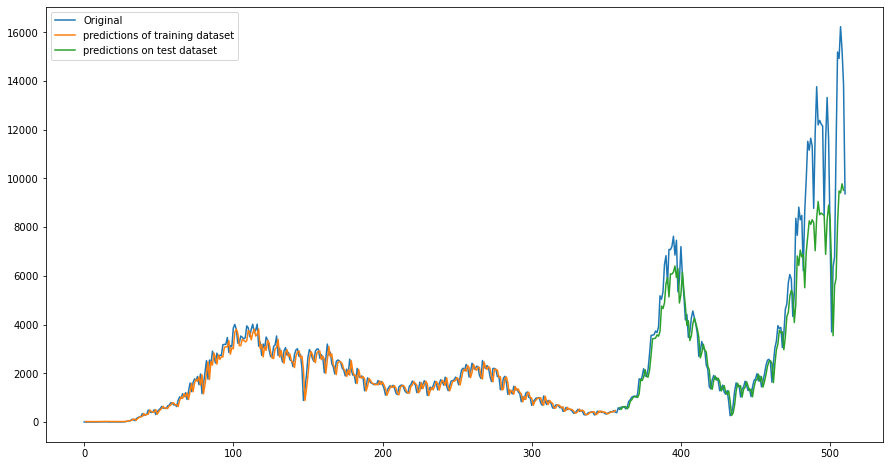

In [21]:
# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(dataset))#original-blue
plt.plot(trainPredictPlot)#orange
plt.plot(testPredictPlot)#green
plt.legend(['Original','predictions of training dataset','predictions on test dataset'])
plt.show()

In [22]:
yhat = model.predict(testX, verbose=0)

In [23]:
for i in range(len(testX)):
    print("Predicted=%s" % (yhat[i]*1000))

Predicted=[36.1949]
Predicted=[31.970915]
Predicted=[37.946033]
Predicted=[38.24802]
Predicted=[39.214497]
Predicted=[33.47898]
Predicted=[37.462902]
Predicted=[51.912968]
Predicted=[55.967777]
Predicted=[62.38376]
Predicted=[64.381096]
Predicted=[65.288925]
Predicted=[62.14165]
Predicted=[70.91621]
Predicted=[107.91087]
Predicted=[104.674706]
Predicted=[113.413605]
Predicted=[132.54788]
Predicted=[115.44359]
Predicted=[113.59285]
Predicted=[131.6614]
Predicted=[168.78673]
Predicted=[210.5234]
Predicted=[211.23282]
Predicted=[212.32281]
Predicted=[220.44516]
Predicted=[217.04521]
Predicted=[229.58823]
Predicted=[293.4636]
Predicted=[286.86194]
Predicted=[301.73483]
Predicted=[350.2177]
Predicted=[364.7259]
Predicted=[316.5282]
Predicted=[374.69727]
Predicted=[374.23816]
Predicted=[379.47992]
Predicted=[394.6813]
Predicted=[365.66943]
Predicted=[388.7309]
Predicted=[301.03976]
Predicted=[322.56754]
Predicted=[379.02744]
Predicted=[331.676]
Predicted=[293.6522]
Predicted=[244.48947]
Pred